In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [54]:
import os
import sys

import pandas as pd

from keras.models import Model
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Add, Activation

from keras.datasets import mnist, cifar10

In [ ]:
def obtain(dir_path):
    """
    Downloads the dataset to ``dir_path``.
    """

    dir_path = os.path.expanduser(dir_path)
    print('Downloading the dataset')
    import urllib
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_train.amat',os.path.join(dir_path,'binarized_mnist_train.amat'))
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_valid.amat',os.path.join(dir_path,'binarized_mnist_valid.amat'))
    urllib.urlretrieve('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_test.amat',os.path.join(dir_path,'binarized_mnist_test.amat'))

    print('Done                     ')

# Model specifications

## Custom Layers

In [51]:
class MaskedConv2D(Conv2D):
    """
    Masked Convolution from [1]. Contains the same implementation of Conv2D from keras, but
    allows one to specify whether the mask type is 'A', 'B', or None.
    
    Params
    ------
    
    mask_type: string, default=None
        Determines the masking type for the convolution from [1].
    
    References
    ----------
    
    [1] https://arxiv.org/pdf/1601.06759.pdf
    """
    
    def __init__(self, filters, kernel_size, padding='same', mask_type=None, **kwargs):
        super(MaskedConv2D, self).__init__(filters, kernel_size, padding=padding, **kwargs)
        self.mask_type = mask_type
        
    def build(self, input_shape):
        super(MaskedConv2D, self).build(input_shape)
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        # assert that the kernel size is odd
        assert self.kernel_size[0] % 2 == 1
        assert self.kernel_size[1] % 2 == 1
        
        center = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        self.mask = np.ones(kernel_shape)
        
        # mask out values right of center
        self.mask[center[0]:, center[1]+1:, :, :] = 0
        
        # mask out values below center
        self.mask[center[0]+1:, :, :, :] = 0
        
        # mask out center if masking type is 'A'
        if self.mask_type == 'A':
            self.mask[center[0], center[0], :, :] = 0
        
        # mask RGB channels
        
        self.mask = K.variable(self.mask)
        
    def call(self, inputs):
        if self.mask_type is None:
            return super(MaskedConv2D, self).call(inputs)
        outputs = K.conv2d(
            inputs,
            self.kernel * self.mask,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        if self.use_bias:
            outputs = K.bias_add(
            outputs,
            self.bias,
            data_format=self.data_format
            )
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [62]:
class ResidualBlock(object):
    
    def __init__(self, filters):
        self.filters = filters
        
    def __call__(self, model):
        block = Activation('relu')(model)
        block = Conv2D(self.filters // 2, 1, activation='relu')(block)
        block = MaskedConv2D(self.filters // 2, 3, mask_type='B', activation='relu')(block)
        block = Conv2D(self.filters, 1)(block)
        
        return Add()([model, block])

# Data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train = x_train/255.
x_test = x_test/255.

x_train = (x_train > np.random.rand(*x_train.shape)).astype(np.int32)
x_test = (x_test > np.random.rand(*x_test.shape)).astype(np.int32)

# Training

In [64]:
x = Input(shape=(28, 28, 1))
y = MaskedConv2D(128, 7, mask_type='A')(x)
y = ResidualBlock(128)(y)
y = Activation('relu')(y)
y = Conv2D(1, 1, activation='sigmoid')(y)
model = Model(x, y)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
masked_conv2d_18 (MaskedConv2D) (None, 28, 28, 128)  6400        input_14[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 28, 28, 128)  0           masked_conv2d_18[0][0]           
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 64)   8256        activation_10[0][0]              
__________________________________________________________________________________________________
masked_con

In [ ]:
def pixel_cnn_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2, -3))

model.compile(loss=pixel_cnn_loss, optimizer='adam')
model.fit(x_train, x_train, batch_size=1000, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 133s 2ms/step - loss: 107.8308
Epoch 2/10
60000/60000 [==============================] - 212s 4ms/step - loss: 100.7603
Epoch 3/10
60000/60000 [==============================] - 322s 5ms/step - loss: 99.6640
Epoch 4/10
60000/60000 [==============================] - 321s 5ms/step - loss: 99.0552
Epoch 5/10
60000/60000 [==============================] - 256s 4ms/step - loss: 98.6632
Epoch 6/10
60000/60000 [==============================] - 139s 2ms/step - loss: 98.4053
Epoch 7/10
60000/60000 [==============================] - 155s 3ms/step - loss: 98.2346
Epoch 8/10
23000/60000 [==========>...................] - ETA: 1:35 - loss: 97.8249

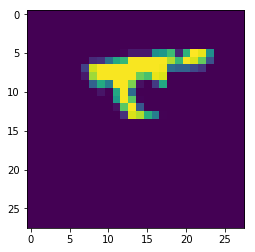

In [92]:
x_half = x_train[:100]
x_half[:, 14:] = 0
imshow(x_half[0][:, :, 0])

In [97]:
x_pred = x_half
for i in range(14, 28):
    for j in range(0, 28):
        pred = model.predict(x_pred)
        x_pred[:, i, j] = pred[:, i, j] > np.random.rand(*pred.shape)

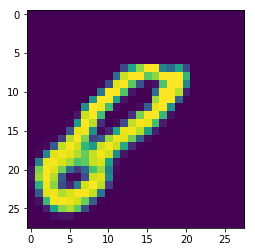

In [103]:
imshow(x_pred[4][:, :, 0])